In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import LabelEncoder

# Download required nltk resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samithlakka/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/samithlakka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True


## Data Exploration

To understand the dataset, we first explore the feature distributions and check for missing values. 
This helps us identify potential issues before applying machine learning models.


In [2]:
# Load dataset
df = pd.read_csv('/Users/samithlakka/Desktop/Capstone 3/WELFake_Dataset.csv')  # Change this to actual dataset path

# Display basic dataset info
print(df.info())
print(df.head())

# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Check for class distribution (real vs fake)
print("Class Distribution:\n", df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB
None
   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2 


## Text Preprocessing

The text data needs to be cleaned and preprocessed before modeling. The following steps are applied:
1. Convert text to lowercase.
2. Remove punctuation and special characters.
3. Remove stopwords.
4. Apply lemmatization to normalize words.

In [3]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# Drop rows with missing values in key columns
df.dropna(subset=['title', 'text'], inplace=True)

# Convert text to lowercase
df['title'] = df['title'].astype(str).str.lower()
df['text'] = df['text'].astype(str).str.lower()

# Remove punctuation & special characters
df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove stopwords & apply lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    words = [lemmatizer.lemmatize(word) for word in words]  # Apply lemmatization
    return ' '.join(words)

df['cleaned_text'] = df['text'].apply(preprocess_text)

print("Text preprocessing complete.")

Text preprocessing complete.


## Feature Selection Justification

- **Text Length**: We analyze the word count of news articles since fake news articles tend to have different distributions in length compared to real news.
- **Preprocessing Choices**: Stopwords removal, punctuation removal, and lemmatization help in reducing noise and improving meaningful text representations.
- **Correlation Analysis**: Pearson correlation is used to understand numerical relationships between key features.


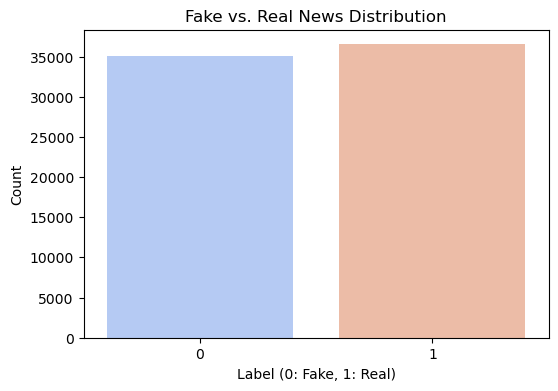

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['label'], palette="coolwarm")
plt.title("Fake vs. Real News Distribution")
plt.xlabel("Label (0: Fake, 1: Real)")
plt.ylabel("Count")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


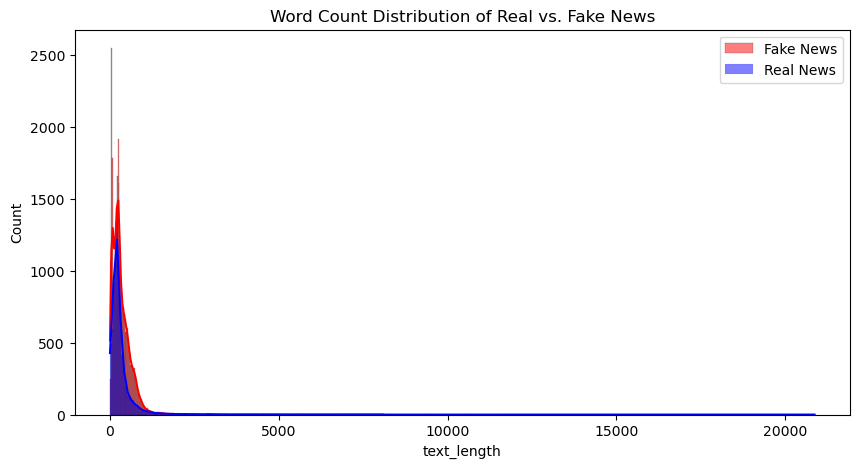

In [5]:
df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(df[df['label']==0]['text_length'], label="Fake News", color="red", kde=True)
sns.histplot(df[df['label']==1]['text_length'], label="Real News", color="blue", kde=True)
plt.legend()
plt.title("Word Count Distribution of Real vs. Fake News")
plt.show()

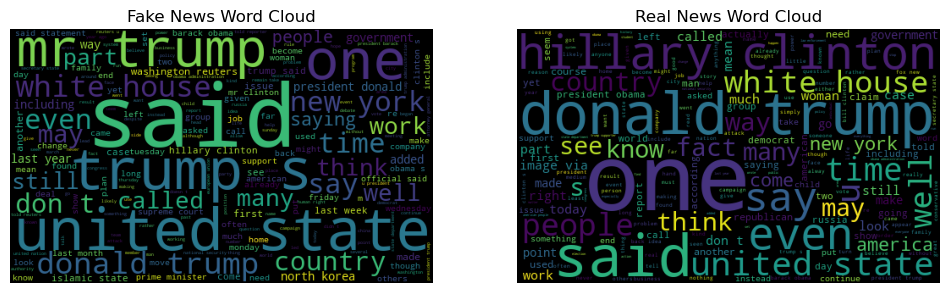

In [6]:
fake_text = " ".join(df[df['label'] == 0]['cleaned_text'])
real_text = " ".join(df[df['label'] == 1]['cleaned_text'])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(width=500, height=300, background_color='black').generate(fake_text))
plt.axis('off')
plt.title("Fake News Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(width=500, height=300, background_color='black').generate(real_text))
plt.axis('off')
plt.title("Real News Word Cloud")

plt.show()

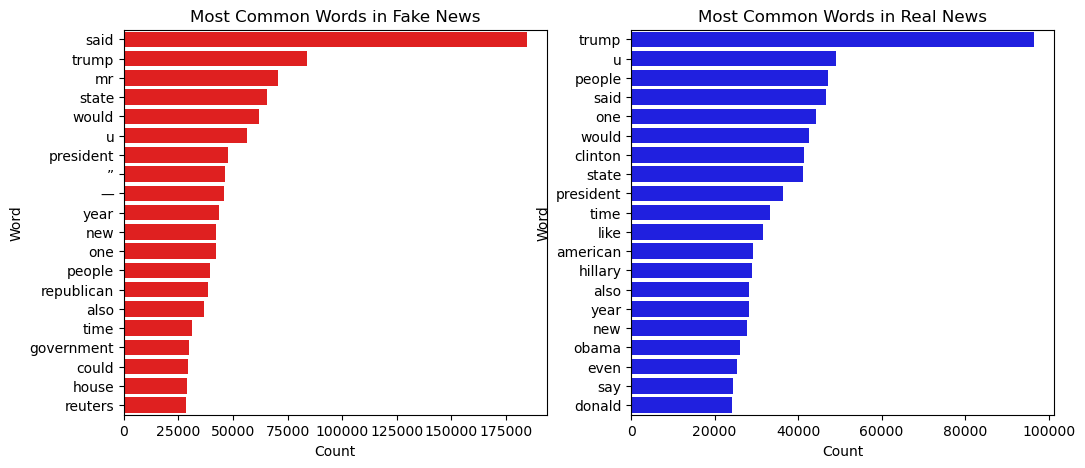

In [7]:
fake_words = Counter(" ".join(df[df['label'] == 0]['cleaned_text']).split()).most_common(20)
real_words = Counter(" ".join(df[df['label'] == 1]['cleaned_text']).split()).most_common(20)

fake_df = pd.DataFrame(fake_words, columns=['Word', 'Count'])
real_df = pd.DataFrame(real_words, columns=['Word', 'Count'])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(y=fake_df['Word'], x=fake_df['Count'], color='red')
plt.title("Most Common Words in Fake News")

plt.subplot(1,2,2)
sns.barplot(y=real_df['Word'], x=real_df['Count'], color='blue')
plt.title("Most Common Words in Real News")

plt.show()

In [8]:
vectorizer = TfidfVectorizer(max_features=5000)  # Extract top 5000 words
X = vectorizer.fit_transform(df['cleaned_text'])

# Convert to DataFrame
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate with original dataset
df_final = pd.concat([df.reset_index(drop=True), X_df], axis=1)

print("TF-IDF Feature Engineering Complete.")

TF-IDF Feature Engineering Complete.


In [9]:
# Define X (features) and y (labels)
X = df_final.drop(columns=['title', 'text', 'cleaned_text', 'label'])  # Drop original text columns
y = df_final['label']

# Train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data splitting complete. Ready for modeling.")

Data splitting complete. Ready for modeling.



## Pearson Correlation Analysis

To understand feature relationships, we compute the correlation matrix and visualize it using a heatmap.


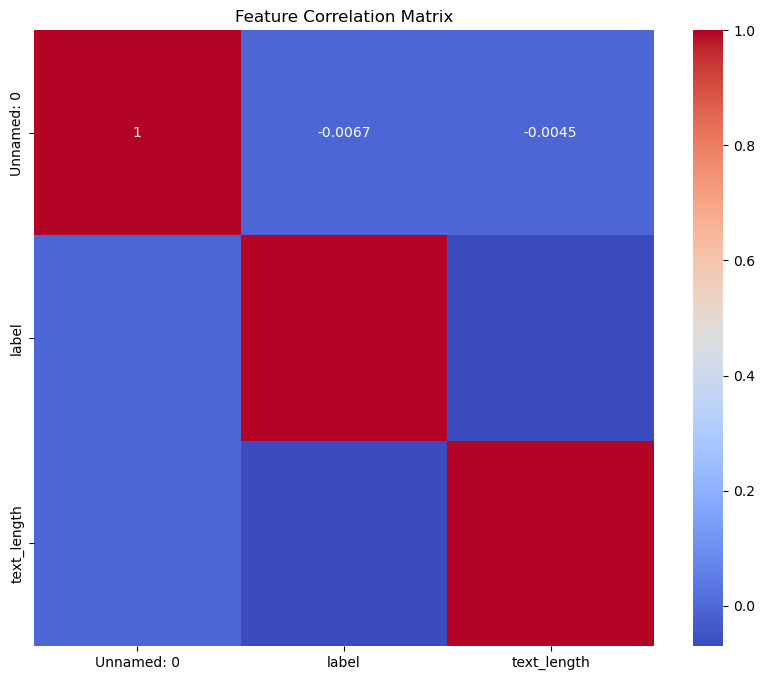

In [11]:

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])

# Compute Pearson correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()